In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csv555/cleaned_data3.csv
/kaggle/input/csv222/cleaned_data.csv
/kaggle/input/csv333/cleaned_data2.csv
/kaggle/input/hot404/cleaned_data4.csv


In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


<ipython-input-9-f008ea196be9>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


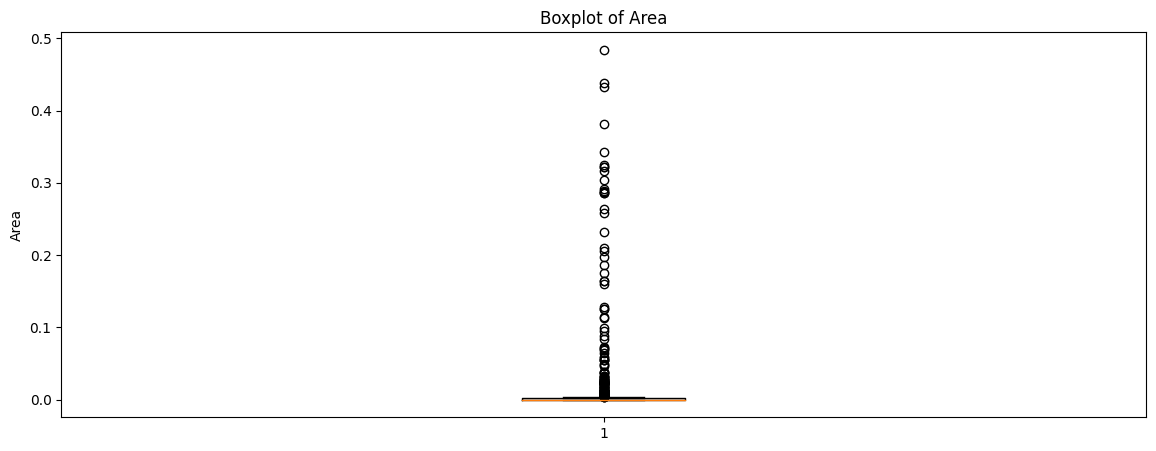

               area     lake_id
count  9.680000e+02  968.000000
mean   5.820114e-04   17.660124
std    8.408503e-04    9.020440
min    1.756977e-08    1.000000
25%    6.760270e-05   10.000000
50%    1.904667e-04   19.000000
75%    7.291752e-04   25.000000
max    4.298708e-03   31.000000


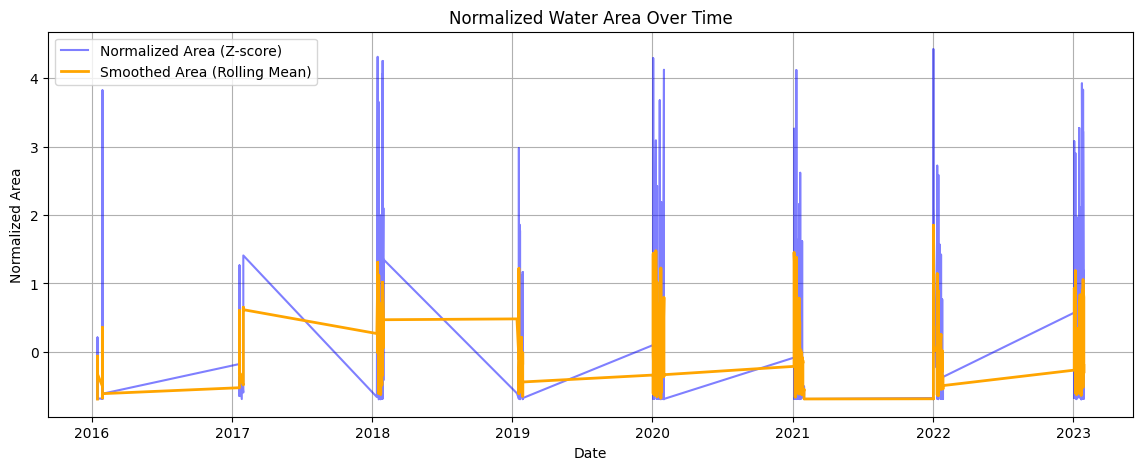

In [9]:

data = pd.read_csv('/kaggle/input/hot404/cleaned_data4.csv')


data['date'] = pd.to_datetime(data['date'], errors='coerce')


data.dropna(subset=['date'], inplace=True)


data.dropna(subset=['area'], inplace=True)


data.sort_values(by='date', inplace=True)


plt.figure(figsize=(14, 5))
plt.boxplot(data['area'])
plt.title('Boxplot of Area')
plt.ylabel('Area')
plt.show()


Q1 = data['area'].quantile(0.25)
Q3 = data['area'].quantile(0.75)
IQR = Q3 - Q1
data = data[(data['area'] >= (Q1 - 1.5 * IQR)) & (data['area'] <= (Q3 + 1.5 * IQR))]


data.set_index('date', inplace=True)


print(data.describe())


scaler = StandardScaler()
data['area'] = scaler.fit_transform(data['area'].values.reshape(-1, 1))


data['smoothed_area'] = data['area'].rolling(window=5).mean()


plt.figure(figsize=(14, 5))
plt.plot(data['area'], label='Normalized Area (Z-score)', alpha=0.5, color='blue')
plt.plot(data['smoothed_area'], label='Smoothed Area (Rolling Mean)', color='orange', linewidth=2)
plt.title('Normalized Water Area Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Area')
plt.legend()
plt.grid()
plt.show()


In [10]:

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

data_values = data['area'].values.reshape(-1, 1)
time_step = 5
X, y = create_dataset(data_values, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6416 - val_loss: 2.7030
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8032 - val_loss: 2.6881
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7121 - val_loss: 2.6733
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5460 - val_loss: 2.6587
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5019 - val_loss: 2.6442
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4903 - val_loss: 2.6297
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5860 - val_loss: 2.6154
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6497 - val_loss: 2.6013
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5706 - val_loss: 2.5873
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5652 - val_loss: 2.5733
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6227 - val_loss: 2.5595
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4888 - val_loss: 2.5458
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5260 - val_loss: 2.5323
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3

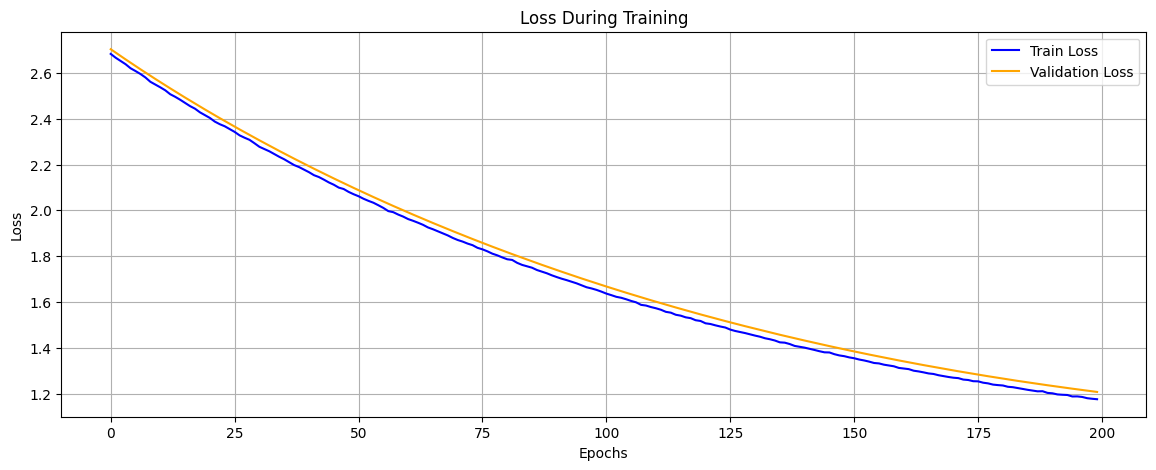

In [12]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)))  # Регуляризация L2
model.add(Dropout(0.5))  # Увеличен Dropout
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)))  # Регуляризация L2
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Уменьшена скорость обучения
              loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

train_losses = []
val_losses = []

for epoch in range(200):
    history = model.fit(X_train, y_train, 
                        epochs=1,  
                        batch_size=16,  
                        validation_split=0.2,
                        verbose=1)

    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0]) 


plt.figure(figsize=(14, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()  

In [13]:

y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


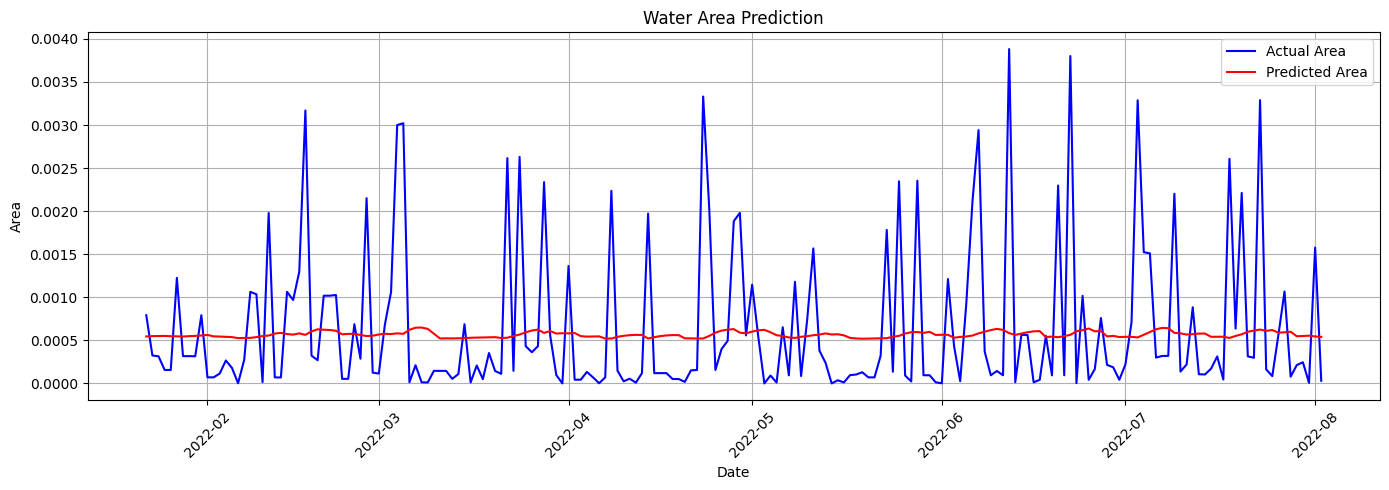

In [14]:

test_length = len(y_test)
start_test_date = data.index[-(test_length + time_step)]
test_dates = pd.date_range(start=start_test_date, periods=test_length, freq='D')

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test, color='blue', label='Actual Area')
plt.plot(test_dates, y_pred, color='red', label='Predicted Area')
plt.title('Water Area Prediction')
plt.xlabel('Date')
plt.ylabel('Area')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
!pip install contextily geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00:00:0100:01


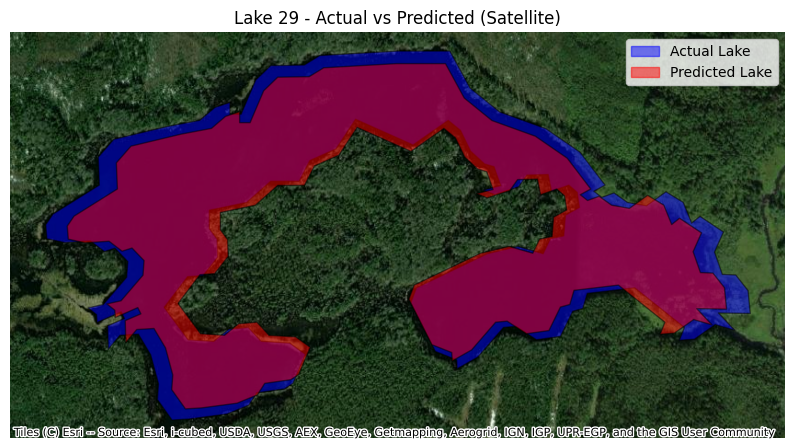

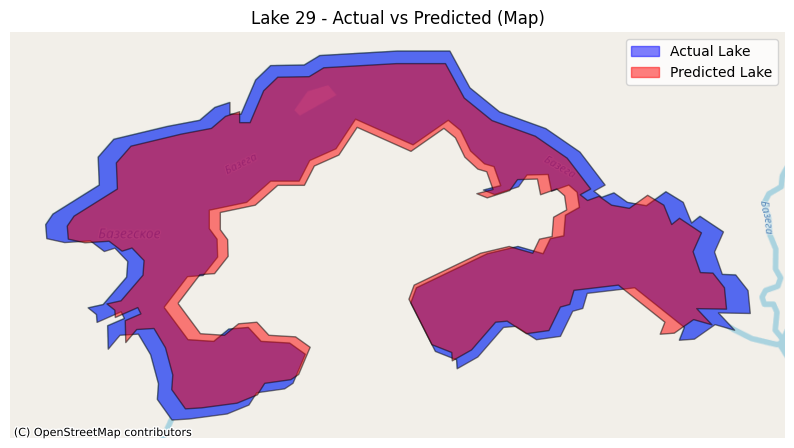

In [39]:
import pandas as pd
import numpy as np
import ast
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import contextily as ctx
import matplotlib.patches as mpatches


data = pd.read_csv('/kaggle/input/hot404/cleaned_data4.csv')

data['coordinates'] = data['coordinates'].apply(ast.literal_eval)

lake_example = data.iloc[0]  
actual_coords = np.array(lake_example['coordinates'])

lake_polygon = Polygon(actual_coords)

lake_gseries = gpd.GeoSeries([lake_polygon], crs="EPSG:4326")

lake_gseries = lake_gseries.to_crs(epsg=3857)

predicted_area = y_pred[0]  
actual_area = y_test[0]     

if actual_area != 0:
    predicted_area_scale_factor = predicted_area / actual_area
else:
    predicted_area_scale_factor = 1 

def scale_polygon(coords, scale_factor):
    center = np.mean(coords, axis=0)
    return center + scale_factor * (coords - center)

predicted_coords = scale_polygon(actual_coords, predicted_area_scale_factor)

predicted_polygon = Polygon(predicted_coords)
predicted_gseries = gpd.GeoSeries([predicted_polygon], crs="EPSG:4326").to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
lake_gseries.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
predicted_gseries.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')

ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

actual_patch = mpatches.Patch(color='blue', alpha=0.5, label='Actual Lake')
predicted_patch = mpatches.Patch(color='red', alpha=0.5, label='Predicted Lake')

ax.set_title(f'Lake {lake_example["lake_id"]} - Actual vs Predicted (Satellite)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(handles=[actual_patch, predicted_patch])
ax.set_axis_off() 

plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
lake_gseries.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
predicted_gseries.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title(f'Lake {lake_example["lake_id"]} - Actual vs Predicted (Map)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend(handles=[actual_patch, predicted_patch])
ax.set_axis_off()  # Отключаем оси для чистоты карты

plt.show()
